In [6]:
%env MY_USERNAME=user

env: MY_USERNAME=user


In [7]:
###############################################################################################################################################################
#----------------------------------------------------------------------SETUP-----------------------------------------------------------------------------------
###############################################################################################################################################################

In [8]:
#Imports
#PySpark data handeling imports
from pyspark.sql import SparkSession, Row #Data handeling and preprocessing
from pyspark.sql.functions import regexp_replace, when, col #Data prepocessing

#Tensorflow & keras model imports
import tensorflow as tf #TensorFlow
from tensorflow.keras import layers, regularizers #Imports to enable CNNs
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping #Model optimisation

#SKLearn data handeling imports
from sklearn.model_selection import train_test_split #dataset splitting
from sklearn.metrics import confusion_matrix #Model evaluations

#Data Visualisation imports
import seaborn as sns #Graphing
import matplotlib.pyplot as plt #Graphing

#Other imports
import numpy as np #Data handeling / storage
from PIL import Image #Pythons image library, used for EDA
import random #Random numbers

In [9]:
#Enviomental variables

#Solves the following envioment error:
#   "Python in worker has different version 3.10 than that in driver 3.11, PySpark cannot run with different minor versions. 
#       Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set."

import sys
import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [10]:
#Create new spark session
spark = SparkSession.builder.appName("ImageProcessing").getOrCreate()

In [11]:
###############################################################################################################################################################
#----------------------------------------------------------------------DATA LOADING & PREPROCESSING------------------------------------------------------------
###############################################################################################################################################################

In [ ]:
#Get image attributes from CSV using spark
labels_df = spark.read.csv("list_attr_celeba.csv", header=True, inferSchema=True)
labels_df = labels_df.select("image_id", "Smiling")
labels_df = labels_df.withColumn("image_id", regexp_replace("image_id", ".jpg", ""))

#Normalise smiling label to be binery and not -1 and 1
#If the values is >= to 0 then the values is set to 1, else the value is 0
#This covnerts the -1 for negative to 0 and the 1 for positive stays the same
smiling_norm = when(col("Smiling") >= 0, 1).otherwise(0)
labels_df = labels_df.withColumn("Smiling", smiling_norm)

#Check
labels_df.printSchema()
labels_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Smiling: integer (nullable = false)

+--------+----+-------+
|image_id|Male|Smiling|
+--------+----+-------+
|  000001|  -1|      1|
|  000002|  -1|      1|
|  000003|   1|      0|
|  000004|  -1|      0|
|  000005|  -1|      0|
+--------+----+-------+
only showing top 5 rows



In [13]:
#Get image file paths
image_dir = "images"
image_files = [(filename.split('.')[0], os.path.join(image_dir, filename)) for filename in \
               os.listdir(image_dir) if filename.endswith('.jpg')]

#Sample only a certain number to reduce computational cost and time
sampling_count = 10000
image_files = image_files[:sampling_count]

#Convert list to spark dataframe
images_df = spark.createDataFrame([Row(image_id=img[0], image_path=img[1]) for img in image_files])

#Check
images_df.printSchema()
images_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- image_path: string (nullable = true)

+--------+-----------------+
|image_id|       image_path|
+--------+-----------------+
|  000001|images\000001.jpg|
|  000002|images\000002.jpg|
|  000003|images\000003.jpg|
|  000004|images\000004.jpg|
|  000005|images\000005.jpg|
+--------+-----------------+
only showing top 5 rows



In [ ]:
#Merge image paths with their corresponding class labels
#Creates a new spark dataframe with the image_path and its class label
#Also drops nulls to clean the data and shows the 5 first rows to check the results
labeled_images_df = images_df.join(labels_df, on="image_id")
labeled_images_df = labeled_images_df.select("image_path", "Smiling")
labeled_images_df = labeled_images_df.dropna()
labeled_images_df = labeled_images_df.dropDuplicates()
labeled_images_df.show(5)

+-----------------+-------+
|       image_path|Smiling|
+-----------------+-------+
|images\000001.jpg|      1|
|images\000002.jpg|      1|
|images\000003.jpg|      0|
|images\000004.jpg|      0|
|images\000005.jpg|      0|
+-----------------+-------+
only showing top 5 rows



In [15]:
###############################################################################################################################################################
#----------------------------------------------------------------------EXPLORATORY DATA ANALYSIS---------------------------------------------------------------
###############################################################################################################################################################

In [16]:
#Create copy of the dataframe using pandas 
#Pandas is used for easier interaction and graphing of the data
labeled_images_pd = labeled_images_df.toPandas()

Not Smiling & Smiling counts:
Smiling
0    5178
1    4822
Name: count, dtype: int64



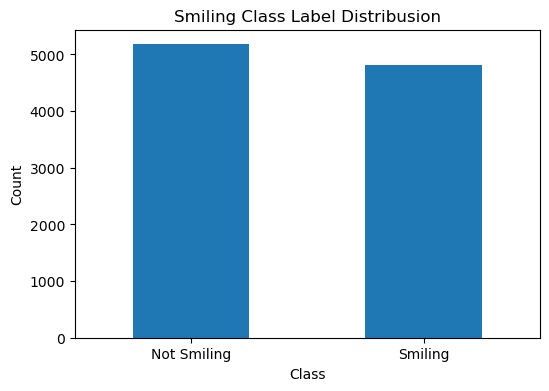

In [17]:
#Output class label data distribusion

#Get class label distribusion
smiling_counts = labeled_images_pd['Smiling'].value_counts()
print(f"Not Smiling & Smiling counts:\n{smiling_counts}\n")

#Create bar chart to visualise the distribusion
plt.figure(figsize=(6, 4))
smiling_counts.plot(kind='bar', title="Smiling Class Label Distribusion")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Smiling', 'Smiling'], rotation=0)
plt.show()

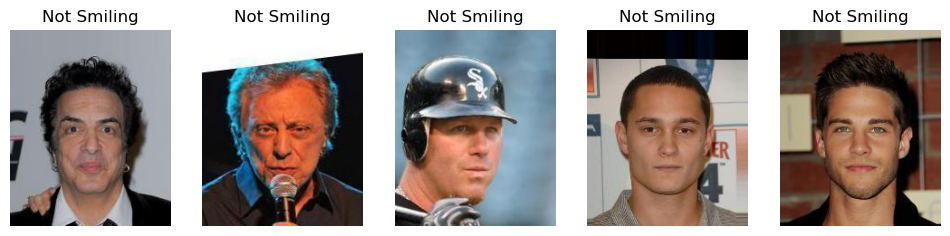

In [18]:
#Show random images with their labels

#Get 5 random image paths
sample_images = random.sample(list(labeled_images_pd[['image_path', 'Smiling']].values), 5)

plt.figure(figsize=(12, 6))

#Load the images
for i, (img_path, classlabel) in enumerate(sample_images):
    #Get label
    if classlabel == 0:
        label = 'Not Smiling'
    else:
        label = 'Smiling'

    #Using pythons image library to load the images
    img = Image.open(img_path)
    #Add image to the subploy
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"{label}")
    plt.axis('off')

plt.show()

In [ ]:
###############################################################################################################################################################
#----------------------------------------------------------------------CREATING THE PIPELINE-------------------------------------------------------------------
###############################################################################################################################################################

In [20]:
#Data processing functions
#These functions work together inorder to load the images and their paired labels.
#Flow of the data processing for the model training pipeline:
#   the create_tf_datasets() function is called
#   create_tf_datasets() splits the data into training, validation and testing
#   create_tf_datasets() creates the training data but calling the data_generator() function
#       This is done is batches, determined by the .prefetch(tf.data.AUTOTUNE) paramiter, to prevent high memory usage
#   data_generator() takes every image_path and label combination and passes them to load_and_preprocess_image()
#   load_and_preprocess_image() then loads and proprocesses the image, it then returns the image file and label to data_generator()
#   data_generator() returns the list of the images and their labels
#   create_tf_datasets() repeats this process until all the images for each dataset has been loaded
#   create_tf_datasets() then returns each dataset

#Function to load and preprocess images
#This is used to get every image file and its correct label
def load_and_preprocess_image(file_path, label, augment=True):
    img = tf.io.read_file(file_path) #Load the image in the file path, loads as bytes not a file
    img = tf.io.decode_jpeg(img, channels=3) #Decodes the bytes back into the image
    img = tf.image.resize(img, [128, 128]) #Resizes the image
    img = img / 255.0 #Normalised the scale of the pixels to 0 and 1 instead of 0 and 255
    return img, label #Returns the image and corresponding label

#Function to load the image paths and labels in batches rather than all at once
#Formats the data in a manner that makes the first feature act as an X/input and the second feature be the Y/output
def data_generator(data):
    #Retreives the image files and the labels from the load_and_preprocess_image function
    for image_path, label in data:
        yield load_and_preprocess_image(image_path, label)

#Function to create the three datasets in TensorFlow datasets
#Uses the data_generator function as a python generator inorder to retreive the data in batches
#Training and validation are used while the model is training and testing is used as the new out-of-sample unseen data
def create_tf_datasets(data, test_size=0.3, val_size=0.2, random_state=42, batch_size=128):
    
    #Split the data into train, validation and test sets
    #This is done differently than usual as I wanted to see what would happen if I tried to apply the theory learnt in DANA8412
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state) 
    val_data, test_data = train_test_split(test_data, test_size=val_size, random_state=random_state)
    
    #Training dataset
    train_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train_data), #Gets every image and label pair
        output_signature=( #Specifies the expected output
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32), #The shape and the type of the images
            tf.TensorSpec(shape=(), dtype=tf.int32) #The type of the labels
        )
        #Shuffle shuffles the dataset in 1000 increments
        #Batch specifies how many entries in every batch
        #Prefetch tells TensorFlow to load the entries in the background in groups, the size is automatically calculated
    ).repeat().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE) 

    #Validation dataset
    #The code works the same as above
    val_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(val_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).repeat().batch(batch_size)

    #Testing dataset
    #The code works the same as above
    test_dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(test_data),
        output_signature=(
            tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
        #As the data size is smaller prefetch and shuffle are not needed
    ).batch(batch_size)

    return train_dataset, val_dataset, test_dataset

In [ ]:
#Model functions
#These functions work together inorder to create a model, compile it, train it, then evalauate it
#Flow for the model training pipeline:
#   The pipeline calles the train_model() function and passes it the model type and the required data
#   train_model() creates the correct model using the model types create model function
#   The create model functions declare the CNN model, compliles it, then returns the compiled model
#   train_model() declares the callbacks then fits the model whilst saving the models training history
#   train_model() then returns the trained model and its training history to the pipeline
#   The pipeline then calls evaluate_model() and passes it the model, testing dataset and the models history
#   evaluate_model() then prints the models training evaluations, its testing evaluations and evaluation graphs
#       The training evaluations include the modls final training and validation scores 
#       The testing evaluations are the loss and accuracy scores of the model using the testing dataset
#       The evaluation graphs include the models training loss and accuracy curves and a confusion matrix of the testing data

#Function to return a CNN model with two convolutional layers
#This creates a very basic model with two convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_two_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with three convolutional layers
#This creates a simple model with three convolutional layers and pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_three_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with four convolutional layers
#This creates a simple model with four convolutional layers, three pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with L2 regularization
#This creates a simple model with four convolutional layers, three pooling layers, one fully connected layer and one output layer
#Every convolutional layer and the fully connected layer have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with two fully connected layers and L2 regularization
#This creates a more compelx model with four convolutional layers, three pooling layers, two fully connected layers and one output layer
#Every convolutional layer and the two fully connected layers have L2 regularisation to prevent overfitting
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_duel_layered_cnn_model_with_regularisation():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to return a CNN model with added data augmentation and regularization
#This creates a simple model with data augmentation, four convolutional layers, three pooling layers, one fully connected layer and one output layer
#The model is complied with the adam optimizer, it uses binary_crossentropy to calculate its loss, and also prints it accuracy
def create_four_conv_cnn_model_with_augmentation_and_regularization():
    model = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#Function to train the model
#The model type is received, the model created, given callbacks, fitted to the data and then returned
def train_model(model_type, train_dataset, val_dataset, epochs=20, batch_size=128):
   
    #Callback functions to prevent overfitting and encorage better convergence
    #A more in-depth explanation of why these approachs were chosen can be found in the accompanying PDF document
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    steps_per_epoch = int((sampling_count*0.7) // batch_size)
    val_steps_per_epoch = int(((sampling_count*0.3)*0.8) // batch_size)

    #Create the model
    model = model_type()

    #The model is then fitted to train
    history = model.fit(
        train_dataset, 
        validation_data=val_dataset, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        callbacks=[lr_scheduler, early_stopping])
    
    return model, history

#Function to evaluate the model
#Creates evaluations scores and graphs to easily interprete the models performance and generalisation ability
def evaluate_model(model, test_dataset, history):

    #Create model predictions on the testing dataset for evaluations
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        #feed the model the inputs and tell it not to train, so its only createing predicitons  
        y_pred.extend((model(images, training=False) > 0.5).numpy().astype(int).flatten())

    #Calculate accuracy scores
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    test_accuracy = np.mean(y_true == y_pred)

    #Print the models last epochs results
    print(f"Final Training Loss: {history.history['loss'][-1]}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    #Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    #Plot training accuracy and loss curves for the taining and validation datasets
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

In [22]:
#Pipeline
#This function is the programs pipeline as it takes in the data and what model to use, then automatically processes the data, 
#   fits the data to the model, trains the model, then evaluates the model
def model_pipeline(data, model_type):
    
    #Load and process the data
    #Loads images, assigned labels, and creates TensorFlow datasets with batches
    train_dataset, val_dataset, test_dataset = create_tf_datasets(data)
    
    #Fit the model
    #Creates the model, trains it, ten returns the model and its training history
    model, history = train_model(model_type, train_dataset, val_dataset, epochs=20)

    #Evaluate the model
    #Prints multiple evaluation scores and graphs
    evaluate_model(model, test_dataset, history)

In [23]:
###############################################################################################################################################################
#----------------------------------------------------------------------APPLYING THE PIPELINES------------------------------------------------------------------
###############################################################################################################################################################

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 472ms/step - accuracy: 0.5667 - loss: 0.7480 - val_accuracy: 0.8181 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.8160 - loss: 0.4195 - val_accuracy: 0.8568 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 446ms/step - accuracy: 0.8741 - loss: 0.3052 - val_accuracy: 0.8776 - val_loss: 0.2728 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.8949 - loss: 0.2510 - val_accuracy: 0.8811 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.9006 - loss: 0.2336 - val_accuracy: 0.8845 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.9130 - loss: 0.1972 - val_accuracy: 0.8841 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9332 - loss: 0.1

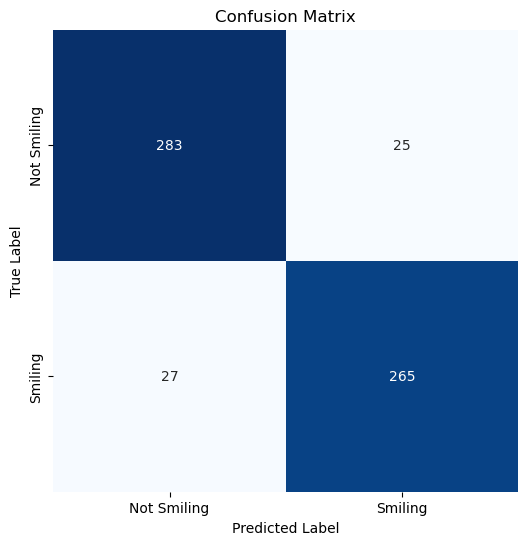

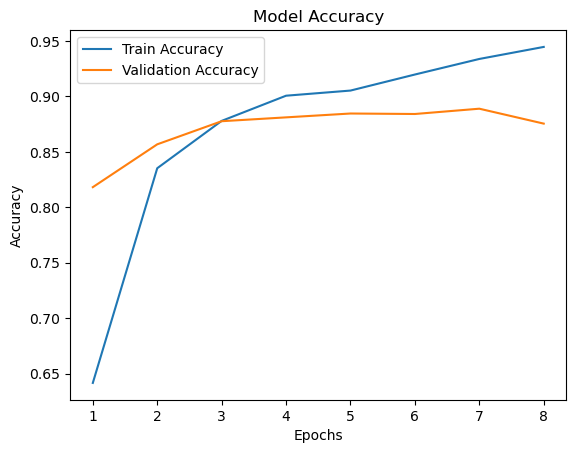

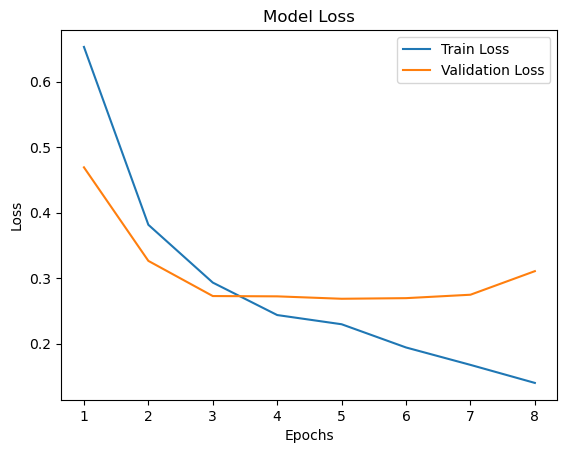

In [24]:
#Two layered conv CNN model
try:
    model_pipeline(labeled_images_df.collect(), create_two_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 474ms/step - accuracy: 0.5400 - loss: 0.7437 - val_accuracy: 0.6762 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - accuracy: 0.7387 - loss: 0.5315 - val_accuracy: 0.8385 - val_loss: 0.3649 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 449ms/step - accuracy: 0.8567 - loss: 0.3286 - val_accuracy: 0.8689 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.8772 - loss: 0.2783 - val_accuracy: 0.8767 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 389ms/step - accuracy: 0.8886 - loss: 0.2613 - val_accuracy: 0.8859 - val_loss: 0.2607 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - accuracy: 0.9080 - loss: 0.2257 - val_accuracy: 0.8885 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - accuracy: 0.9116 - loss: 0.

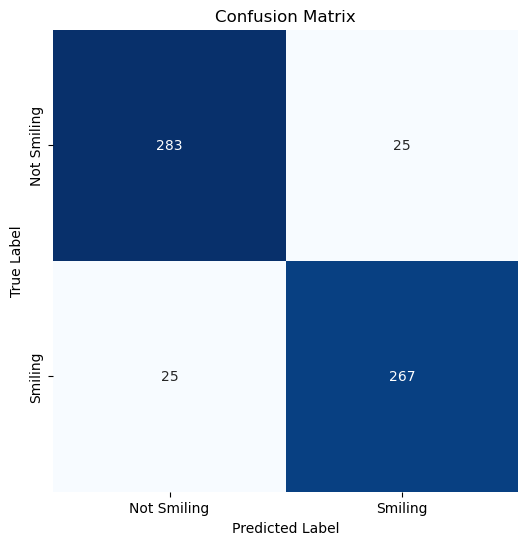

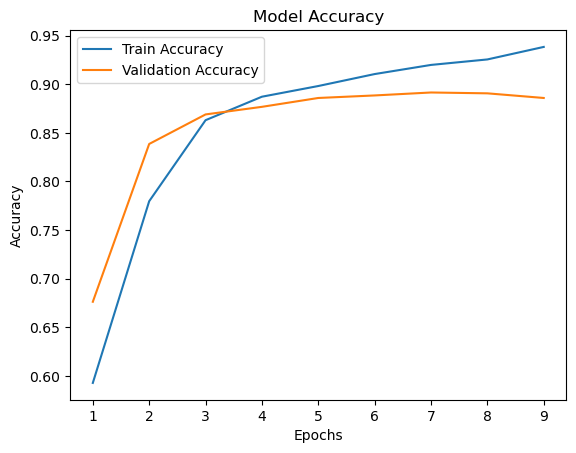

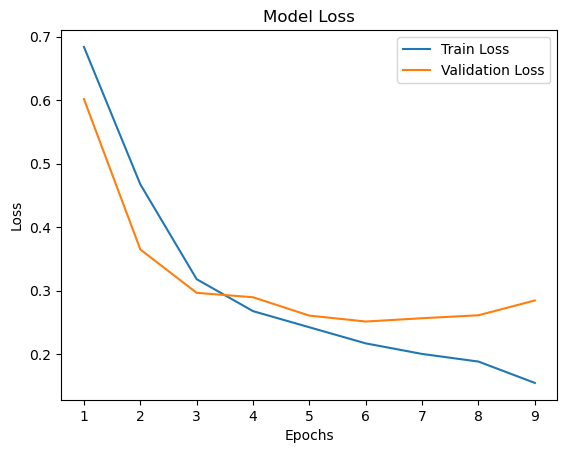

In [25]:
#Three layered conv CNN model
try:
    model_pipeline(labeled_images_df.collect(), create_three_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.5245 - loss: 0.7193 - val_accuracy: 0.6402 - val_loss: 0.6286 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - accuracy: 0.7058 - loss: 0.5746 - val_accuracy: 0.8086 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - accuracy: 0.8359 - loss: 0.3658 - val_accuracy: 0.8546 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.8738 - loss: 0.3015 - val_accuracy: 0.8720 - val_loss: 0.2853 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.8914 - loss: 0.2704 - val_accuracy: 0.8772 - val_loss: 0.2721 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 442ms/step - accuracy: 0.8983 - loss: 0.2380 - val_accuracy: 0.8876 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 425ms/step - accuracy: 0.9106 - loss: 0.

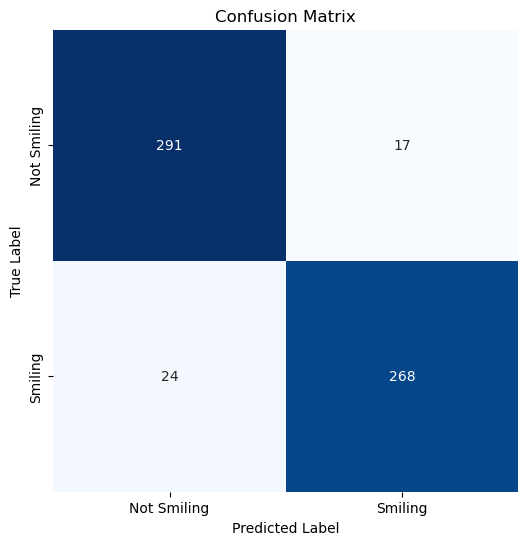

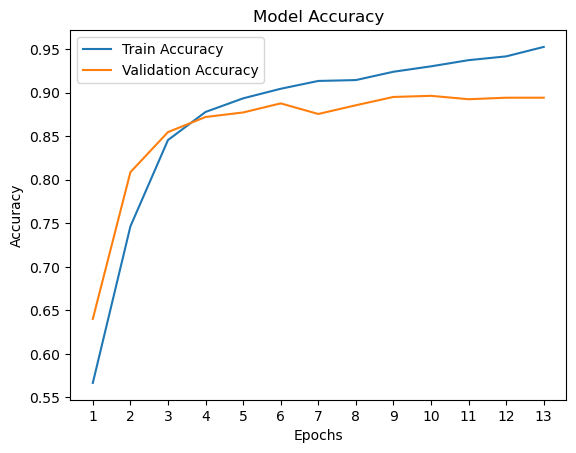

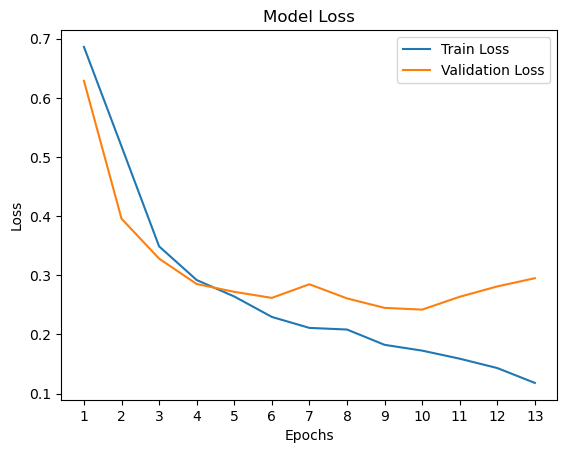

In [26]:
#Four layered conv CNN model
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 477ms/step - accuracy: 0.5353 - loss: 1.2330 - val_accuracy: 0.6211 - val_loss: 0.7651 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 462ms/step - accuracy: 0.5893 - loss: 0.7386 - val_accuracy: 0.7296 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - accuracy: 0.7746 - loss: 0.5569 - val_accuracy: 0.8273 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 430ms/step - accuracy: 0.8380 - loss: 0.4559 - val_accuracy: 0.8477 - val_loss: 0.4141 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.8578 - loss: 0.4170 - val_accuracy: 0.8624 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - accuracy: 0.8678 - loss: 0.3836 - val_accuracy: 0.8381 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - accuracy: 0.8693 - loss: 0.

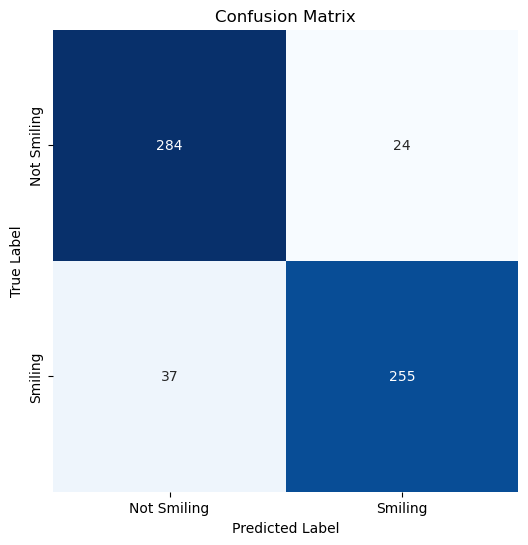

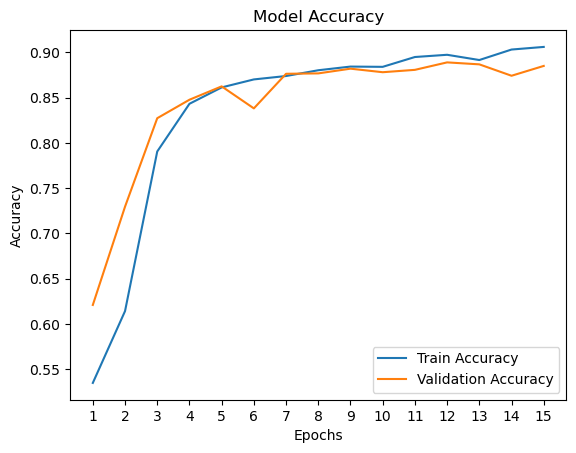

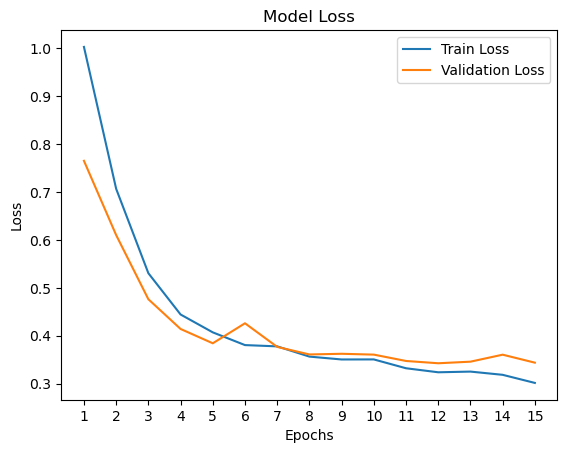

In [27]:
#CNN model with regularisation
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model_with_regularisation)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.5207 - loss: 1.4452 - val_accuracy: 0.5304 - val_loss: 0.9086 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 493ms/step - accuracy: 0.5212 - loss: 0.8659 - val_accuracy: 0.5252 - val_loss: 0.7844 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 483ms/step - accuracy: 0.5159 - loss: 0.7710 - val_accuracy: 0.5308 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 443ms/step - accuracy: 0.5039 - loss: 0.7353 - val_accuracy: 0.5321 - val_loss: 0.7198 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 407ms/step - accuracy: 0.5146 - loss: 0.7174 - val_accuracy: 0.5299 - val_loss: 0.7091 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 432ms/step - accuracy: 0.5113 - loss: 0.7088 - val_accuracy: 0.5286 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 431ms/step - accuracy: 0.5127 - loss: 0.

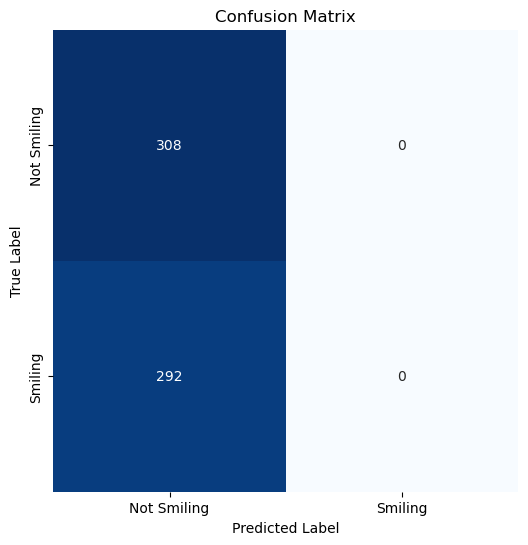

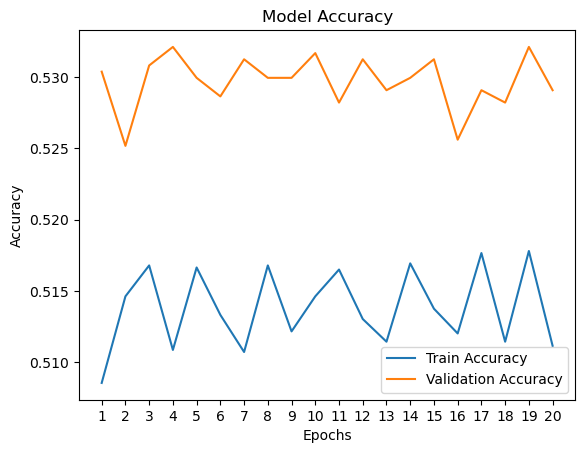

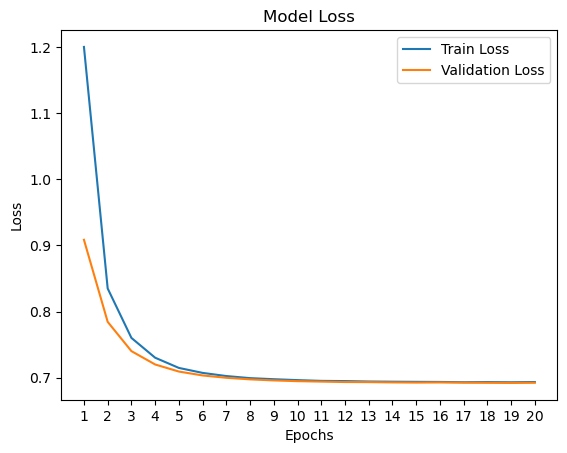

In [28]:
#Double CNN layered model with regularisation
try:
    model_pipeline(labeled_images_df.collect(), create_duel_layered_cnn_model_with_regularisation)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.5133 - loss: 1.3402 - val_accuracy: 0.5304 - val_loss: 0.8737 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.5255 - loss: 0.8500 - val_accuracy: 0.6168 - val_loss: 0.7779 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 495ms/step - accuracy: 0.5867 - loss: 0.7739 - val_accuracy: 0.6519 - val_loss: 0.7087 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 464ms/step - accuracy: 0.6284 - loss: 0.7193 - val_accuracy: 0.6914 - val_loss: 0.6726 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 424ms/step - accuracy: 0.6691 - loss: 0.6820 - val_accuracy: 0.7795 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - accuracy: 0.7241 - loss: 0.6194 - val_accuracy: 0.7960 - val_loss: 0.4920 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 24s 451ms/step - accuracy: 0.7596 - loss: 0.

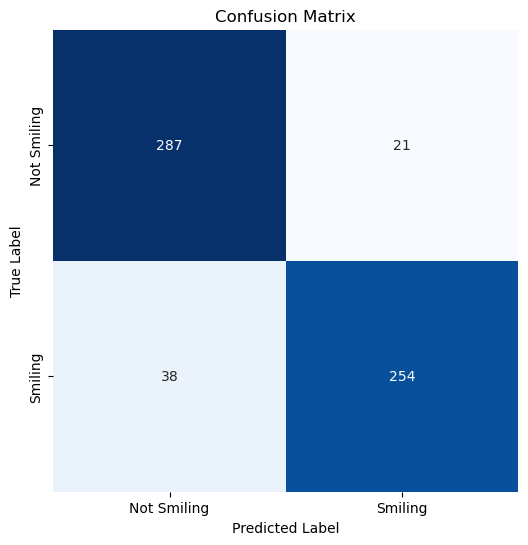

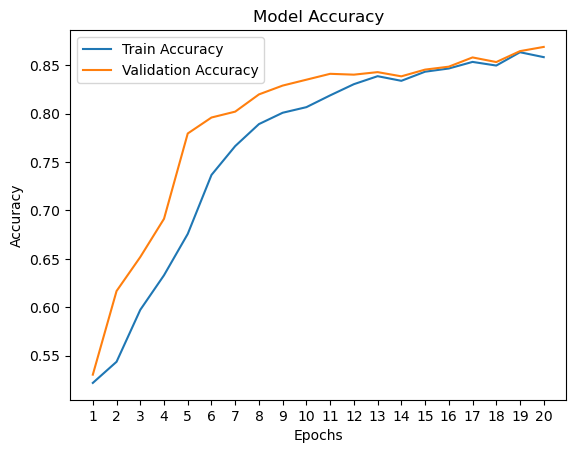

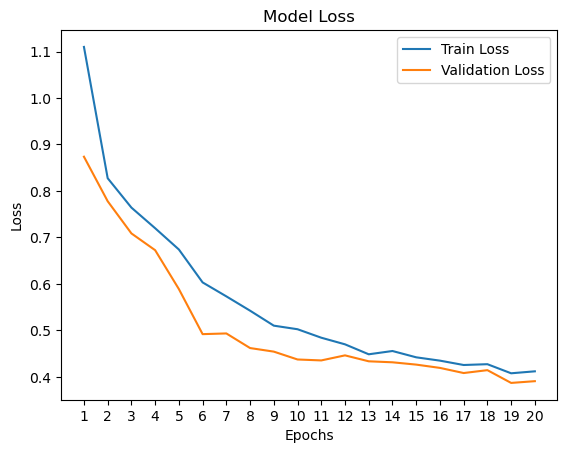

In [ ]:
#CNN model with data augmenation and regularization
try:
    model_pipeline(labeled_images_df.collect(), create_four_conv_cnn_model_with_augmentation_and_regularization)
except Exception as e:
    print("An error occurred:", e)

#---Evaluation metrics---
#Final Training Loss:           -
#Final Training Accuracy:       -
#Final Validation Loss:         -
#Final Validation Accuracy:     -
#Out-Of-Sample Test Loss:       -
#Out-Of-Sample Test Accuracy:   -
#Accuracy training curve:       -
#Loss training curve:           -
#Confusion matrix:              -
#Overall findings: -

In [31]:
###############################################################################################################################################################
#----------------------------------------------------------------------ADDITIONAL MODELS-----------------------------------------------------------------------
###############################################################################################################################################################

In [32]:
###############################################################################################################################################################
#----------------------------------------------------------------------USER INPUT------------------------------------------------------------------------------
###############################################################################################################################################################